# Report Without Ground Truth v1.0
## Input prameters

In [18]:
import pandas as pd
import h5py
import matplotlib.pyplot as plt
import numpy as np
from configparser import ConfigParser

pd.options.display.float_format = lambda x: '{:,.1e}'.format(x) if x>1e6 else '{:,.1f}'.format(x)
pd.options.display.max_colwidth = 100

configFile='no_gt_report.config'
parser = ConfigParser()
parser.read(configFile)

no_gt_statistics_unfiltered= parser.get('NOGTReport', 'h5_statistics', fallback='no_gt_statistics_unfiltered.h5')
no_gt_statistics_filtered = parser.get('NOGTReport', 'filtered_h5_statistics', fallback='no_gt_statistics_filtered.h5')
no_gt_statistics_unfiltered_wgs = parser.get('NOGTReport', 'h5_statistics_wgs', fallback='no_gt_statistics_unfiltered_wgs.h5')
no_gt_statistics_filtered_wgs = parser.get('NOGTReport', 'filtered_h5_statistics_wgs', fallback='no_gt_statistics_filtered_wgs.h5')

is_somatic = parser.getboolean('NOGTReport', 'is_somatic', fallback=False)
filtered_vcf = parser.get('NOGTReport', 'filtered_vcf',fallback='filtered_vcf.vcf.gz')
annotation_intervals_names=parser.get('NOGTReport', 'annotation_intervals_names',fallback='annotation_intervals_names').split(',')
interval_list = parser.get('NOGTReport', 'interval_list')
ref_fasta = parser.get('NOGTReport', 'ref_fasta',fallback='Homo_sapiens_assembly38.fasta')
ref_fasta_dict = parser.get('NOGTReport', 'ref_fasta_dict', fallback='Homo_sapiens_assembly38.dict')

prmNames=['run_id','pipeline_version',
          'h5_statistics', 'filtered_h5_statistics',
          'h5_statistics_wgs', 'filtered_h5_statistics_wgs','annotation_intervals_names','is_somatic','filtered_vcf',
          'interval_list'
         ]

prm={}
for name in prmNames:
    prm[name]=parser.get('NOGTReport', name)
    
h5outfile = parser.get('NOGTReport', 'h5_output', fallback='no_gt_report.h5')

prmdf = pd.DataFrame.from_dict(prm, orient='index',columns=['value']).reindex(prmNames)
prmdf.to_hdf(h5outfile, key="parameters")
prmdf

,value
run_id,test_staging
pipeline_version,1.1.5
h5_statistics,no_gt_statistics_unfiltered.h5
filtered_h5_statistics,no_gt_statistics_filtered.h5
h5_statistics_wgs,no_gt_statistics_unfiltered_wgs.h5
filtered_h5_statistics_wgs,no_gt_statistics_filtered_wgs.h5
annotation_intervals_names,"LCR,exome,mappability,hmers_7_and_higher"
is_somatic,true
filtered_vcf,/data/test_staging.annotated.AF.vcf.gz
interval_list,/data/wgs_calling_regions.hg38.interval_list


In [19]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import sys
from os.path import join as pjoin
from matplotlib.lines import Line2D

home=os.environ['HOME']
sys.path.append('/VariantCalling/src/')
from python.utils import revcomp
import python.vcftools as vcftools
import python.pipelines.vcf_pipeline_utils as vcf_pipeline_utils

ModuleNotFoundError: No module named 'python'

In [20]:
SMALL_SIZE = 12
MEDIUM_SIZE = 18
BIGGER_SIZE = 26
TITLE_SIZE = 36
FIGSIZE = (16, 8)
GRID = True
COLORS = [
    "blue",
    "red",
    "green",
    "magenta",
    "black",
    "brown",
    "orange",
    "salmon",
    "teal",
    "coral",
    "lime",
    "purple",
    "cyan",
    "lavender",
    "turquoise",
    "darkgreen",
    "tan",
    "lightblue",
    "pink",
    "yellow",
    "gold",
]

plt.rc("font", size=SMALL_SIZE)  # controls default text sizes
plt.rc("axes", titlesize=TITLE_SIZE)  # fontsize of the axes title
plt.rc("axes", labelsize=BIGGER_SIZE)  # fontsize of the x and y labels
plt.rc("axes", grid=GRID)  # is grid on
plt.rc("axes", prop_cycle=plt.cycler(color=COLORS))
plt.rc("xtick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("ytick", labelsize=MEDIUM_SIZE)  # fontsize of the tick labels
plt.rc("legend", fontsize=MEDIUM_SIZE)  # legend fontsize
plt.rc("figure", titlesize=TITLE_SIZE)  # fontsize of the figure title
plt.rc("figure", figsize=FIGSIZE)  # size of the figure

# Variants Statistics

In [21]:
import pandas as pd
def metric_table_annotation(h5_path, annotation_name='none'):

    JexlExpression = annotation_name
    metric_table = pd.DataFrame(index=['nEvalVariants','nDeletions','nInsertions','nSNPs','nTi','nTv','tiTvRatio',
                                       'SNP_to_indel_ratio','indel_novelty_rate','insertion_to_deletion_ratio'],
                                columns=['novel','known','all'])
    # CompOverlap
    CompOverlap = pd.read_hdf(h5_path,'eval_CompOverlap')
    CompOverlap[['nEvalVariants']] = CompOverlap[['nEvalVariants']].apply(lambda x : pd.to_numeric(x,errors='coerce'))
    metric_table.loc['nEvalVariants','known']=int(CompOverlap.loc[(CompOverlap['JexlExpression']==JexlExpression) & (CompOverlap['Novelty']=='known'),'nEvalVariants'].values[0])
    metric_table.loc['nEvalVariants','novel']=int(CompOverlap.loc[(CompOverlap['JexlExpression']==JexlExpression) & (CompOverlap['Novelty']=='novel'),'nEvalVariants'].values[0])
    metric_table.loc['nEvalVariants','all']=int(CompOverlap.loc[(CompOverlap['JexlExpression']==JexlExpression) & (CompOverlap['Novelty']=='all'),'nEvalVariants'].values[0])
    # CountVariants
    CountVariants = pd.read_hdf(h5_path,'eval_CountVariants')
    CountVariants[["nDeletions","nInsertions","nSNPs"]] = CountVariants[["nDeletions","nInsertions","nSNPs"]
                                                                       ].apply(lambda x : pd.to_numeric(x,errors='coerce'))
    metric_table.loc['nDeletions','known']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='known'),'nDeletions'].values[0])
    metric_table.loc['nDeletions','novel']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='novel'),'nDeletions'].values[0])
    metric_table.loc['nDeletions','all']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='all'),'nDeletions'].values[0])
    metric_table.loc['nInsertions','known']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='known'),'nInsertions'].values[0])
    metric_table.loc['nInsertions','novel']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='novel'),'nInsertions'].values[0])
    metric_table.loc['nInsertions','all']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='all'),'nInsertions'].values[0])
    metric_table.loc['nSNPs','known']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='known'),'nSNPs'].values[0])
    metric_table.loc['nSNPs','novel']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='novel'),'nSNPs'].values[0])
    metric_table.loc['nSNPs','all']=int(CountVariants.loc[(CountVariants['JexlExpression']==JexlExpression) & (CountVariants['Novelty']=='all'),'nSNPs'].values[0])
    # TiTvVariantEvaluator
    TiTvVariantEvaluator = pd.read_hdf(h5_path,'eval_TiTvVariantEvaluator')
    TiTvVariantEvaluator[["nTi","nTv","tiTvRatio"]] = TiTvVariantEvaluator[["nTi","nTv","tiTvRatio"]
                                                                       ].apply(lambda x : pd.to_numeric(x,errors='coerce'))
    metric_table.loc['nTi','known']=int(TiTvVariantEvaluator.loc[(TiTvVariantEvaluator['JexlExpression']==JexlExpression) & (TiTvVariantEvaluator['Novelty']=='known'),'nTi'].values[0])
    metric_table.loc['nTi','novel']=int(TiTvVariantEvaluator.loc[(TiTvVariantEvaluator['JexlExpression']==JexlExpression) & (TiTvVariantEvaluator['Novelty']=='novel'),'nTi'].values[0])
    metric_table.loc['nTi','all']=int(TiTvVariantEvaluator.loc[(TiTvVariantEvaluator['JexlExpression']==JexlExpression) & (TiTvVariantEvaluator['Novelty']=='all'),'nTi'].values[0])
    metric_table.loc['nTv','known']=int(TiTvVariantEvaluator.loc[(TiTvVariantEvaluator['JexlExpression']==JexlExpression) & (TiTvVariantEvaluator['Novelty']=='known'),'nTv'].values[0])
    metric_table.loc['nTv','novel']=int(TiTvVariantEvaluator.loc[(TiTvVariantEvaluator['JexlExpression']==JexlExpression) & (TiTvVariantEvaluator['Novelty']=='novel'),'nTv'].values[0])
    metric_table.loc['nTv','all']=int(TiTvVariantEvaluator.loc[(TiTvVariantEvaluator['JexlExpression']==JexlExpression) & (TiTvVariantEvaluator['Novelty']=='all'),'nTv'].values[0])
    metric_table.loc['tiTvRatio','known']=float(TiTvVariantEvaluator.loc[(TiTvVariantEvaluator['JexlExpression']==JexlExpression) & (TiTvVariantEvaluator['Novelty']=='known'),'tiTvRatio'].values[0])
    metric_table.loc['tiTvRatio','novel']=float(TiTvVariantEvaluator.loc[(TiTvVariantEvaluator['JexlExpression']==JexlExpression) & (TiTvVariantEvaluator['Novelty']=='novel'),'tiTvRatio'].values[0])
    metric_table.loc['tiTvRatio','all']=float(TiTvVariantEvaluator.loc[(TiTvVariantEvaluator['JexlExpression']==JexlExpression) & (TiTvVariantEvaluator['Novelty']=='all'),'tiTvRatio'].values[0])

    IndelSummary = pd.read_hdf(h5_path,'eval_IndelSummary')
    IndelSummary[["SNP_het_to_hom_ratio",
                       "SNP_to_indel_ratio",
                       "indel_het_to_hom_ratio",
                       "indel_novelty_rate",
                       "insertion_to_deletion_ratio"]] = IndelSummary[["SNP_het_to_hom_ratio",
                       "SNP_to_indel_ratio",
                       "indel_het_to_hom_ratio",
                       "indel_novelty_rate",
                       "insertion_to_deletion_ratio"]].apply(lambda x : pd.to_numeric(x,errors='coerce'))
    
    metric_table.loc['SNP_to_indel_ratio','known']=float(IndelSummary.loc[(IndelSummary['JexlExpression']==JexlExpression) & (IndelSummary['Novelty']=='known'),'SNP_to_indel_ratio'].values[0])
    metric_table.loc['SNP_to_indel_ratio','novel']=float(IndelSummary.loc[(IndelSummary['JexlExpression']==JexlExpression) & (IndelSummary['Novelty']=='novel'),'SNP_to_indel_ratio'].values[0])
    metric_table.loc['SNP_to_indel_ratio','all']=float(IndelSummary.loc[(IndelSummary['JexlExpression']==JexlExpression) & (IndelSummary['Novelty']=='all'),'SNP_to_indel_ratio'].values[0])
    metric_table.loc['indel_novelty_rate','known']=float(IndelSummary.loc[(IndelSummary['JexlExpression']==JexlExpression) & (IndelSummary['Novelty']=='known'),'indel_novelty_rate'].values[0])
    metric_table.loc['indel_novelty_rate','novel']=float(IndelSummary.loc[(IndelSummary['JexlExpression']==JexlExpression) & (IndelSummary['Novelty']=='novel'),'indel_novelty_rate'].values[0])
    metric_table.loc['indel_novelty_rate','all']=float(IndelSummary.loc[(IndelSummary['JexlExpression']==JexlExpression) & (IndelSummary['Novelty']=='all'),'indel_novelty_rate'].values[0])
    metric_table.loc['insertion_to_deletion_ratio','known']=float(IndelSummary.loc[(IndelSummary['JexlExpression']==JexlExpression) & (IndelSummary['Novelty']=='known'),'insertion_to_deletion_ratio'].values[0])
    metric_table.loc['insertion_to_deletion_ratio','novel']=float(IndelSummary.loc[(IndelSummary['JexlExpression']==JexlExpression) & (IndelSummary['Novelty']=='novel'),'insertion_to_deletion_ratio'].values[0])
    metric_table.loc['insertion_to_deletion_ratio','all']=float(IndelSummary.loc[(IndelSummary['JexlExpression']==JexlExpression) & (IndelSummary['Novelty']=='all'),'insertion_to_deletion_ratio'].values[0])

    if annotation_name == 'none':
        annotation_name = 'wgs'
    mi = pd.MultiIndex.from_tuples([(annotation_name, itm) for itm in list(metric_table.index)],names=['regions','metrics'])
    metric_table.set_index(mi,inplace=True)
    return metric_table

In [22]:
def metric_table(annotation_names,h5_path, h5_path_filtered):
    frames = []
    for annotation_name in annotation_names:
        cur_unfiltetred_result = metric_table_annotation(h5_path, annotation_name)
        cur_filtered_result = metric_table_annotation(h5_path_filtered, annotation_name)
        cur_result = pd.concat([cur_unfiltetred_result,cur_filtered_result],axis=1, keys=["unfiltered","filtered"])
        frames.append(cur_result)
    result = pd.concat(frames)
    return result

metric_table(['none']+annotation_intervals_names,no_gt_statistics_unfiltered, no_gt_statistics_filtered)

unfiltered                   \
                                                    novel   known      all   
regions            metrics                                                   
wgs                nEvalVariants                   573578  954498  1528076   
                   nDeletions                      185204   56794   241998   
                   nInsertions                     206021   48453   254474   
                   nSNPs                           177287  844987  1022274   
                   nTi                              75652  569909   645561   
                   nTv                             101187  274277   375464   
                   tiTvRatio                          0.8     2.1      1.7   
                   SNP_to_indel_ratio                 0.5     7.4      2.0   
                   indel_novelty_rate               100.0     0.0     77.6   
                   insertion_to_deletion_ratio        1.1     0.9      1.1   
LCR                nEvalVariants                    93940   66283   160223   
                   nDeletions                       26365   22192    48557   
                   nInsertions                      19059   13466    32525   
                   nSNPs                            46212   27201    73413   
                   nTi                              22297   13581    35878   
                   nTv                              23646   13516    37162   
                   tiTvRatio                          0.9     1.0      1.0   
                   SNP_to_indel_ratio                 1.0     0.6      0.8   
                   indel_novelty_rate               100.0     0.0     52.4   
                   insertion_to_deletion_ratio        0.7     0.6      0.7   
exome              nEvalVariants                     7343    5297    12640   
                   nDeletions                        2077      65     2142   
                   nInsertions                       3734      51     3785   
                   nSNPs                             1503    5179     6682   
                   nTi                                465    3801     4266   
                   nTv                               1037    1366     2403   
                   tiTvRatio                          0.5     2.8      1.8   
                   SNP_to_indel_ratio                 0.3    43.3      1.1   
                   indel_novelty_rate               100.0     0.0     98.0   
                   insertion_to_deletion_ratio        1.8     0.8      1.8   
mappability        nEvalVariants                   558364  948691  1507055   
                   nDeletions                      183222   56663   239885   
                   nInsertions                     203071   48388   251459   
                   nSNPs                           167083  839376  1006459   
                   nTi                              71381  566291   637672   
                   nTv                              95280  272294   367574   
                   tiTvRatio                          0.8     2.1      1.7   
                   SNP_to_indel_ratio                 0.4     7.4      2.0   
                   indel_novelty_rate               100.0     0.0     77.4   
                   insertion_to_deletion_ratio        1.1     0.9      1.1   
hmers_7_and_higher nEvalVariants                        0       0        0   
                   nDeletions                           0       0        0   
                   nInsertions                          0       0        0   
                   nSNPs                                0       0        0   
                   nTi                                  0       0        0   
                   nTv                                  0       0        0   
                   tiTvRatio                          0.0     0.0      0.0   
                   SNP_to_indel_ratio                 NaN     NaN      NaN   
                   indel_novelty_rate                 NaN     NaN    


<ul>
<li><b>nEvalVariants</b>- the number of variants <br></li>
<li><b>nDeletions</b>- the number of variants determined to be deletions <br></li>
<li><b>nInsertions</b>- the number of variants determined to be insertions <br></li>
<li><b>nSNPs</b>- the number of variants determined to be single-nucleotide polymorphisms <br></li>
<li><b>nTi</b>- number of transition variants (A↔G or T↔C) <br></li>
<li><b>nTv</b>- number of transversion variants (A↔T or G↔C) <br></li>
<li><b>SNP_to_indel_ratio</b>- n_SNPs divided by n_indels <br></li>
<li><b>indel_novelty_rate</b>- n_novel_indels divided by n_indels<br></li>
<li><b>insertion_to_deletion_ratio</b>- n_insertions divided by n_deletions<br></li>
</ul>





In [23]:
from IPython.display import display, Markdown

if is_somatic:
    display(Markdown("""# Distribution of Allele fractions
    Histogram of 100 bins of Allele fraction for the somatic data. \n
    """))

# Distribution of Allele fractions
    Histogram of 100 bins of Allele fraction for the somatic data. 

    

In [24]:
def af_hist_graph(filtered_af_hist, annotation_name='none'):
    nbins = 100
    bin_edges = pd.Series(np.arange(0,1,1/nbins))

    for group in filtered_af_hist.columns:

        plt.plot(bin_edges,filtered_af_hist[group]/np.sum(filtered_af_hist[group])*100, alpha=0.5, label=group, linewidth = '3')
        plt.legend(loc='upper right')
        plt.xlabel("Estimated allele fraction")
        plt.ylabel("% Variants")
        plt.title(f'{annotation_name} Pass filter AF histogram', fontsize=24)
    plt.show()

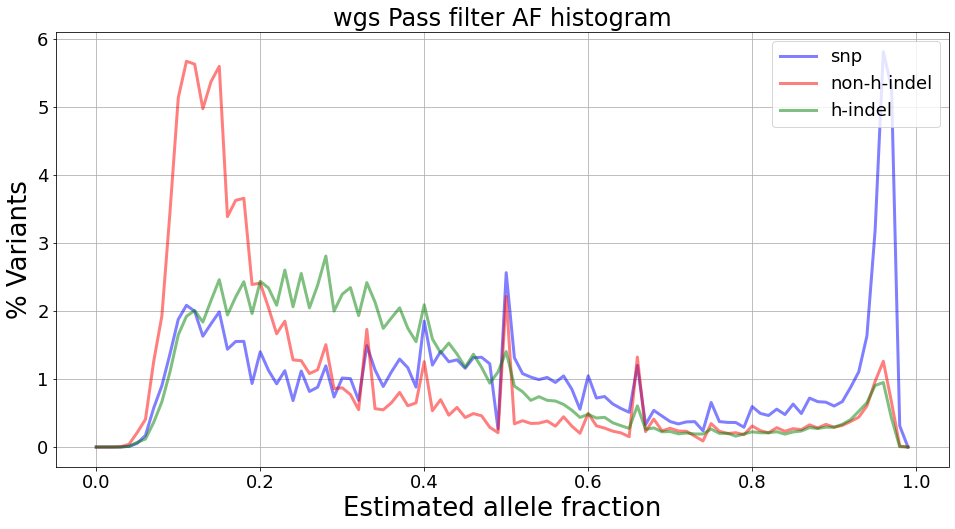

In [25]:
if is_somatic:
    filtered_af_hist = pd.read_hdf(no_gt_statistics_filtered_wgs,'af_hist')
    af_hist_graph(filtered_af_hist,'wgs')

In [26]:
# FDR Analysis

filtered_vcf_df = vcftools.get_vcf_df(filtered_vcf)
run_fpr = not all(filtered_vcf_df['filter'] == '')

NameError: name 'vcftools' is not defined

In [27]:
if run_fpr:
    display(Markdown("""# FDR Analysis
    """))

NameError: name 'run_fpr' is not defined

In [28]:
if run_fpr:
    novel_vcf_df = filtered_vcf_df[filtered_vcf_df['db']!=True]
    novel_pass_vcf_df = novel_vcf_df[novel_vcf_df['filter']=='PASS']

NameError: name 'run_fpr' is not defined

<!--  ## MetricsCollection -->

In [29]:
def FDR_graph(interval_size,fprs,pass_fps, ax=None,title = None,color='darkorange'):

    params = {'legend.fontsize': 'x-large',
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'large',
         'ytick.labelsize':'large'}
    plt.rcParams.update(params)
    if ax is None:
        plt.figure()
        ax = plt.gca()
        ax.set_aspect('equal', 'datalim')
        #ax.set_aspect('equal', 'box')
        plt.axis('scaled')
        ax.grid()
        ax.rcParams.update(params)
    plt.sca(ax)
    
    fprs = pd.Series(fprs).dropna()
    pass_fprs = pd.Series(pass_fps).dropna()
    select_size = len(fprs)
    pass_select_size = len(pass_fprs)
    expected_below = fprs*interval_size
    pass_expected_below = pass_fprs*interval_size
    actual = np.arange(select_size)
    pass_actual = np.arange(pass_select_size)
    plt.xlabel('Expected # FP variants', fontsize=30)
    plt.ylabel('Observed #variants', fontsize=30)
    plt.title(title, fontsize=30)
    plt.rcParams['axes.labelsize'] = 30
    plt.rcParams['axes.titlesize'] = 30

    
    plt.loglog(expected_below, expected_below,color='royalblue')
    plt.loglog(expected_below, actual,'.',color='darkorange')
    plt.loglog(pass_expected_below, pass_actual,'.',color='green')
    plt.legend(labels=['Expected','All', 'Pass'])
    
    
    

In [ ]:
# interval_size 10**6
if run_fpr:
    interval_obj = vcf_pipeline_utils.IntervalFile(interval_list, ref_fasta, ref_fasta_dict)
    interval_size = vcf_pipeline_utils.bed_file_length(interval_obj.as_bed_file())

In [31]:
if run_fpr:
    fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(24, 8))
    fprs= np.sort(novel_vcf_df[(novel_vcf_df['variant_type']=='snp')]['fpr']/(10**6))
    pass_fps = np.sort(novel_pass_vcf_df[(novel_pass_vcf_df['variant_type']=='snp')]['fpr']/(10**6))
    FDR_graph(interval_size,fprs,pass_fps,axes[0],'FDR novel snp')

    fprs= np.sort(novel_vcf_df[(novel_vcf_df['variant_type']=='non-h-indel')]['fpr']/(10**6))
    pass_fps = np.sort(novel_pass_vcf_df[(novel_pass_vcf_df['variant_type']=='non-h-indel')]['fpr']/(10**6))
    FDR_graph(interval_size,fprs,pass_fps,axes[1],'FDR novel non-h-indel')

    fprs= np.sort(novel_vcf_df[(novel_vcf_df['variant_type']=='h-indel')]['fpr']/(10**6))
    pass_fps = np.sort(novel_pass_vcf_df[(novel_pass_vcf_df['variant_type']=='h-indel')]['fpr']/(10**6))
    FDR_graph(interval_size,fprs,pass_fps,axes[2],'FDR novel h-indel')

    fig.tight_layout()
    plt.show()

NameError: name 'run_fpr' is not defined

# Snp statistics
Histogram for motif alterations

In [32]:

base_colors = {"A": "b", "C": "r", "T": "y", "G": "g"}
dpi = 150

def plot_motifs0_bars(motifs_0,ax=None, title_prefix = ""):
    if ax is None:
        plt.figure(figsize=(3, 6))
        ax = plt.gca()
    plt.sca(ax)

    x = (motifs_0).sort_index(ascending=False)
    
    bbox_extra_artists = [
        plt.title(f"{title_prefix} {x.sum():.1E} SNPs".replace("E+0", "E"), fontsize=17)
    ]
    (x / motifs_0.sum() * 100).plot.barh(
        color=[base_colors.get(v) for v in x.index.get_level_values("ref")],
        ax=ax,
    )
    plt.yticks(
        ticks=range(6),
        labels=[
            f"{ref}->{alt}" for ref, alt in x.index.values
        ],
    )
    for j, (_, row) in enumerate(x.to_frame().iterrows()):
        bbox_extra_artists += [
            plt.text(
                row["size"] / motifs_0.sum() * 101,
                j + 0.03,
                f"{row['size']:.1E}".replace("E+0", "E"),
            )
        ]
    plt.ylabel("")
    plt.xlabel("Frequency [%]", fontsize=18)
    # plt.xlim(0, ax.get_xlim()[1]+0.1)
    ax.spines["top"].set_visible(False)
    ax.spines["right"].set_visible(False)
    return bbox_extra_artists



In [33]:
import pandas as pd
def snps_statistics_annot(no_gt_statistics_unfiltered,no_gt_statistics_filtered, annotation_name='none'):   
    motifs = pd.read_hdf(no_gt_statistics_unfiltered,'snp_motifs')
    filtered_motifs = pd.read_hdf(no_gt_statistics_filtered,'snp_motifs')    
    
    motifs_0 = motifs.reset_index()
    motifs_0 = (
        motifs_0.assign(ref=motifs_0["ref_motif"].str.slice(1, 2))
        .groupby(["ref", "alt_1"])
        .agg({"size": "sum"})
    )["size"]


    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(10, 6))


    plot_motifs0_bars(motifs_0, axes[0],title_prefix=annotation_name)

    motifs_0 = filtered_motifs.reset_index()
    motifs_0 = (
        motifs_0.assign(ref=motifs_0["ref_motif"].str.slice(1, 2))
        .groupby(["ref", "alt_1"])
        .agg({"size": "sum"})
    )["size"]
    plot_motifs0_bars(motifs_0, axes[1], title_prefix=f"{annotation_name}, Filter Pass")

    fig.tight_layout()

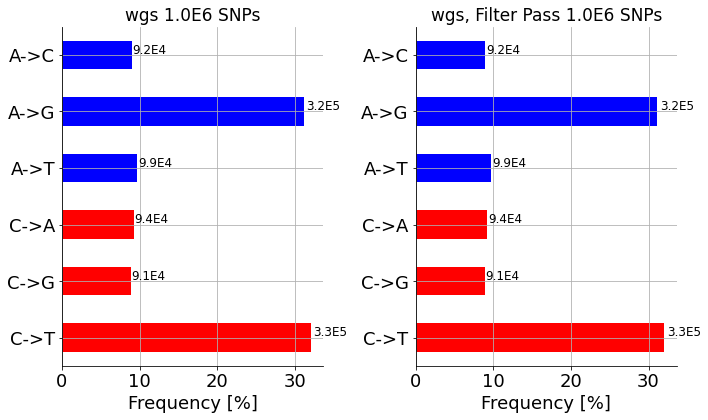

In [34]:
snps_statistics_annot(no_gt_statistics_unfiltered_wgs,no_gt_statistics_filtered_wgs,'wgs')


## Trinucleotide Heatmap
Heatmap for motif alterations in trinucleotide context

In [35]:
def plot_heatmap(motifs,ax=None, title_prefix = ""):
    
    if ax is None:
        plt.figure()
        ax = plt.gca()
    plt.sca(ax)

    plt.title(f"{title_prefix} Trinucleotide context", fontsize=20)
    
    x = (motifs / motifs.sum()).reset_index()
    x = x.assign(
        ref=x["ref_motif"].str.slice(1, 2),
        alt_motif=x["ref_motif"].str.slice(0, 1)
        + x["alt_1"]
        + x["ref_motif"].str.slice(2),
        left=x["ref_motif"].str.slice(0, 1),
        right=x["ref_motif"].str.slice(2),
    )
    x = x.assign(
        family=x.apply(
            lambda y: f"{y['ref']}->{y['alt_1']}",
            axis=1,
        )
    )
    
    table_str = "\n".join(
        (
            x["ref_motif"]
            + "->"
            + x["alt_motif"]
            + "  "
            + (x["size"]).apply(lambda x: f"{x:.1%}")
        )
        .loc[x.sort_values("size", ascending=False).head(12).index]
        .values
    )
    x = x.pivot_table(
        index=[
            "family",
            "left",
        ],
        columns=["right"],
        values="size",
    ).sort_index(ascending=False)
    
    ax.text(
        0.25,
        -0.15,
        table_str,
        transform=ax.transAxes,
        fontsize=16,
        verticalalignment="top",
        bbox=dict(boxstyle="round", facecolor="#EEEEEE"),
    )

    bbox_extra_artists = list()
    data = np.concatenate((x.iloc[:12, :], x.iloc[12:, :]), axis=1) * 100
    plt.imshow(data, cmap="viridis")
    cbar = plt.colorbar()
    cbar.ax.get_yaxis().set_ticks(
        range(
            int(np.ceil(min(cbar.ax.get_yaxis().get_ticklocs()))),
            1 + int(max(cbar.ax.get_yaxis().get_ticklocs())),
            10 if (int(max(cbar.ax.get_yaxis().get_ticklocs()))-int(np.ceil(min(cbar.ax.get_yaxis().get_ticklocs())))>10) else 1))
    cbar.ax.set_ylabel("Frequency [%]", fontsize=24, rotation=270, labelpad=30)
    plt.xticks(range(8), list(x.columns) + list(x.columns))
    plt.yticks(range(12), x.iloc[:12, :].index.get_level_values("left"))
    plt.ylabel("Left base")
    plt.xlabel("Right base")
    plt.grid()
    xlim = plt.gca().get_xlim()
    ylim = plt.gca().get_ylim()
    plt.plot(np.ones(2) * (xlim[0] + (xlim[1] - xlim[0]) / 2), ylim, "-w", linewidth=2)
    plt.plot(xlim, np.ones(2) * (ylim[0] + (ylim[1] - ylim[0]) / 3), "-w", linewidth=2)
    plt.plot(
        xlim, np.ones(2) * (ylim[0] + (ylim[1] - ylim[0]) * 2 / 3), "-w", linewidth=2
    )

    X = np.repeat(
        [
            [
                (xlim[0] + (xlim[1] - xlim[0]) / 4),
                (xlim[0] + (xlim[1] - xlim[0]) * 3 / 4),
            ]
        ],
        3,
        axis=0,
    )
    Y = np.repeat(
        [
            [
                (ylim[0] + (ylim[1] - ylim[0]) * 5 / 6),
                (ylim[0] + (ylim[1] - ylim[0]) * 3 / 6),
                (ylim[0] + (ylim[1] - ylim[0]) / 6),
            ]
        ],
        2,
        axis=0,
    ).T
    T = np.vstack(
        (
            x.iloc[:12:4, :].index.get_level_values("family").values,
            x.iloc[12::4, :].index.get_level_values("family").values,
        )
    ).T

    for xx, yy, tt in zip(X.flatten(), Y.flatten(), T.flatten()):
        plt.text(xx, yy, tt, color="#BB5555", fontsize=28, ha="center", va="center")


In [36]:
def heatmap_annot(no_gt_statistics_unfiltered,no_gt_statistics_filtered):
    
    #for no_gt_statistics_unfiltered,no_gt_statistics_filtered,annotation_name in zip(no_gt_statistics_unfiltered_files,no_gt_statistics_filtered_files,annotation_intervals_names):   
    motifs = pd.read_hdf(no_gt_statistics_unfiltered,'snp_motifs')
    filtered_motifs = pd.read_hdf(no_gt_statistics_filtered,'snp_motifs')   

    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(17, 10))

    plot_heatmap(motifs, axes[0], 'wgs')
    plot_heatmap(filtered_motifs, axes[1], f"wgs Filter Pass")

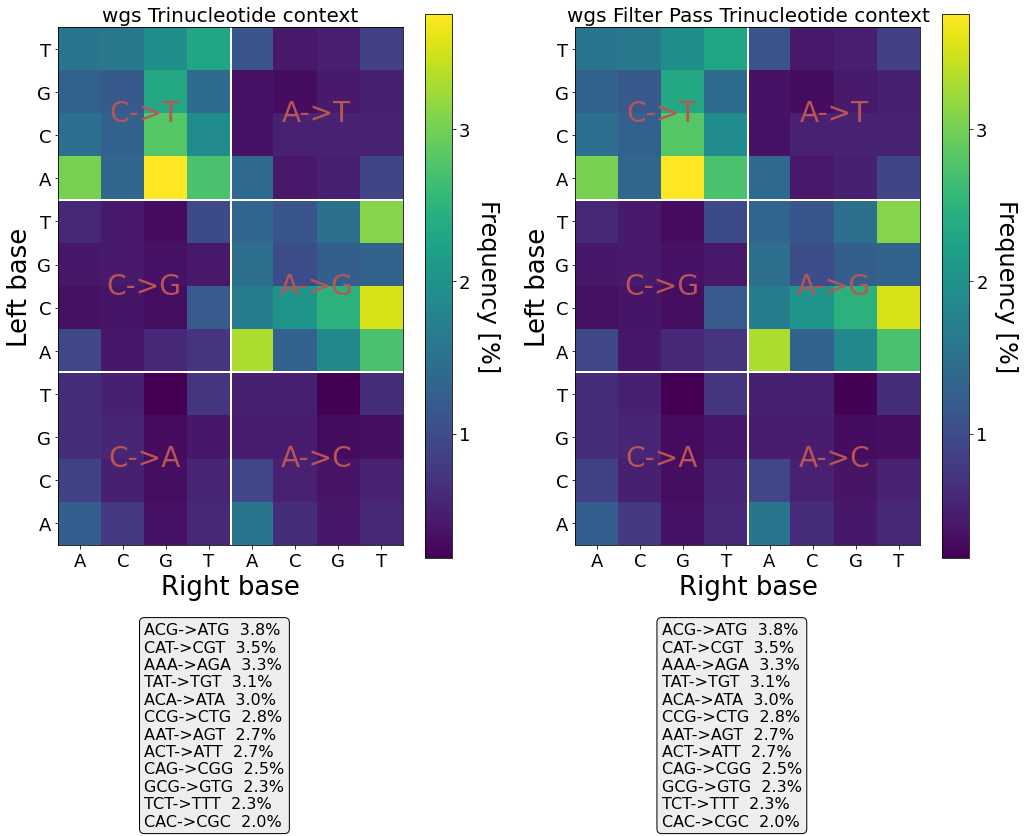

In [37]:
heatmap_annot(no_gt_statistics_unfiltered_wgs,no_gt_statistics_filtered_wgs)

# INDEL statistics

## Distribution of indel lengths

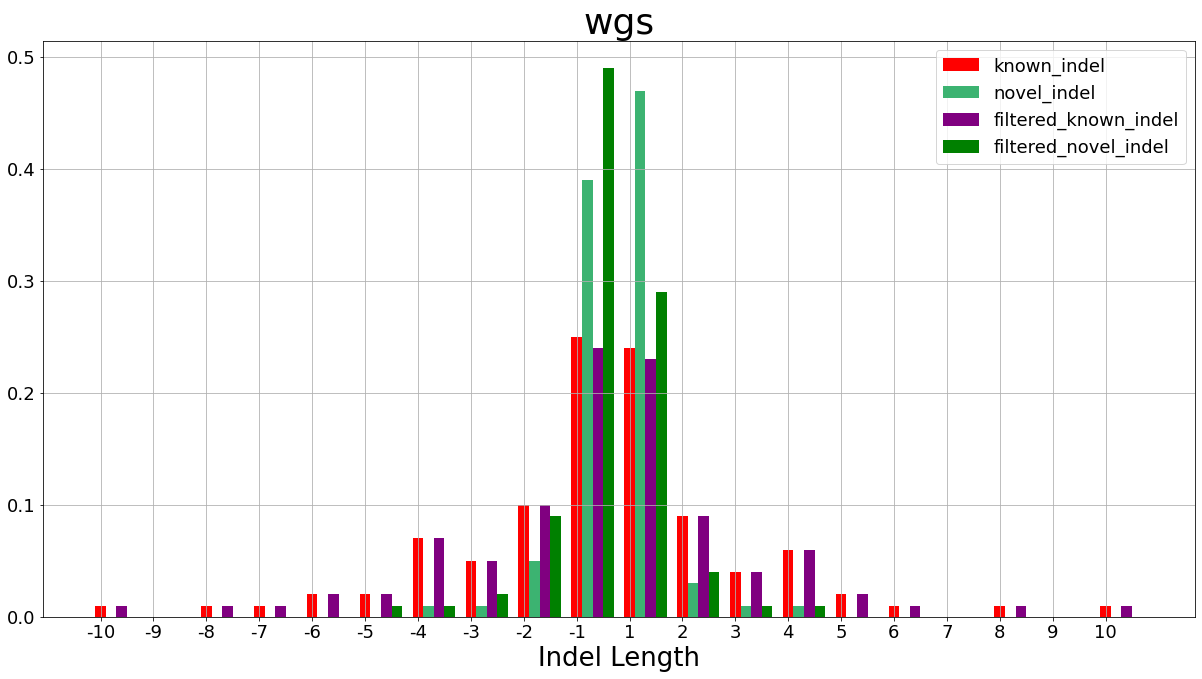

In [38]:
def ins_del_hete_graph_annot(known_indel,novel_indel,filtered_known_indel,filtered_novel_indel, title=None):
    X = np.arange(20)
    fig = plt.figure()
    ax = fig.add_axes([0,0,1,1])
    
    ax.bar(X + 0.00, known_indel, color = 'r', width = 0.20)
    ax.bar(X + 0.20, novel_indel, color = 'mediumseagreen', width = 0.20)
    ax.bar(X + 0.40, filtered_known_indel, color = 'purple', width = 0.20)
    ax.bar(X + 0.60, filtered_novel_indel, color = 'g', width = 0.20)

    ax.set_title(title)
    ax.set_xticks(np.arange(0,20))
    ax.set_xticklabels([-10,-9,-8,-7,-6,-5,-4,-3,-2,-1,1,2,3,4,5,6,7,8,9,10])
    ax.legend(labels=['known_indel', 'novel_indel', 'filtered_known_indel', 'filtered_novel_indel'])
    ax.set_xlabel('Indel Length')
    
    

def ins_del_hete_graph(no_gt_statistics_unfiltered,no_gt_statistics_filtered):
    
    #for no_gt_statistics_unfiltered,no_gt_statistics_filtered,annotation_name in zip(no_gt_statistics_unfiltered_files,no_gt_statistics_filtered_files,annotation_intervals_names):
        
    IndelLengthHistogram = pd.read_hdf(no_gt_statistics_unfiltered,'eval_IndelLengthHistogram')
    filtered_IndelLengthHistogram = pd.read_hdf(no_gt_statistics_filtered,'eval_IndelLengthHistogram')

    known_indel = IndelLengthHistogram[IndelLengthHistogram['Novelty']=='known']['Freq'].astype(float)
    novel_indel = IndelLengthHistogram[IndelLengthHistogram['Novelty']=='novel']['Freq'].astype(float)

    filtered_known_indel = filtered_IndelLengthHistogram[filtered_IndelLengthHistogram['Novelty']=='known']['Freq'].astype(float)
    filtered_novel_indel = filtered_IndelLengthHistogram[filtered_IndelLengthHistogram['Novelty']=='novel']['Freq'].astype(float)

    ins_del_hete_graph_annot(known_indel,
               novel_indel,
               filtered_known_indel,
               filtered_novel_indel,
               title='wgs')
        
ins_del_hete_graph(no_gt_statistics_unfiltered_wgs,no_gt_statistics_filtered_wgs)

## Insertion Deletion Statistics for h-mer indels
Number of 1-base insretion deletions in hmer of each length

In [39]:
if not is_somatic:
    display(Markdown("""## Heterozygous
    """))

In [40]:
def ins_del_hete_graph(ins_del, ax, title):
    X = np.arange(12)
    
    ax.bar(X + 0.00, ins_del.iloc[0], color = 'r', width = 0.3)
    ax.bar(X + 0.3, ins_del.iloc[1], color = 'mediumseagreen', width = 0.3)
    ax.bar(X + 0.00, -ins_del.iloc[2], color = 'purple', width = 0.3)
    ax.bar(X + 0.3, -ins_del.iloc[3], color = 'g', width = 0.3)

    ax.set_title(title, fontsize=18)
    ax.set_xticks(np.arange(0,12))
    ax.set_xticklabels(pd.Series(np.arange(1,13)).apply(lambda x: f"hmer {x}"),rotation=45)
    ax.legend(labels=['ins A', 'ins G', 'del A', 'del G'])
    ax.set_yticks(ax.get_yticks())
    
    ax.set_yticklabels([abs(x).astype(int) for x in ax.get_yticks()])
    ax.set_ylabel("Deletion        /       Insertion",

               loc="center")

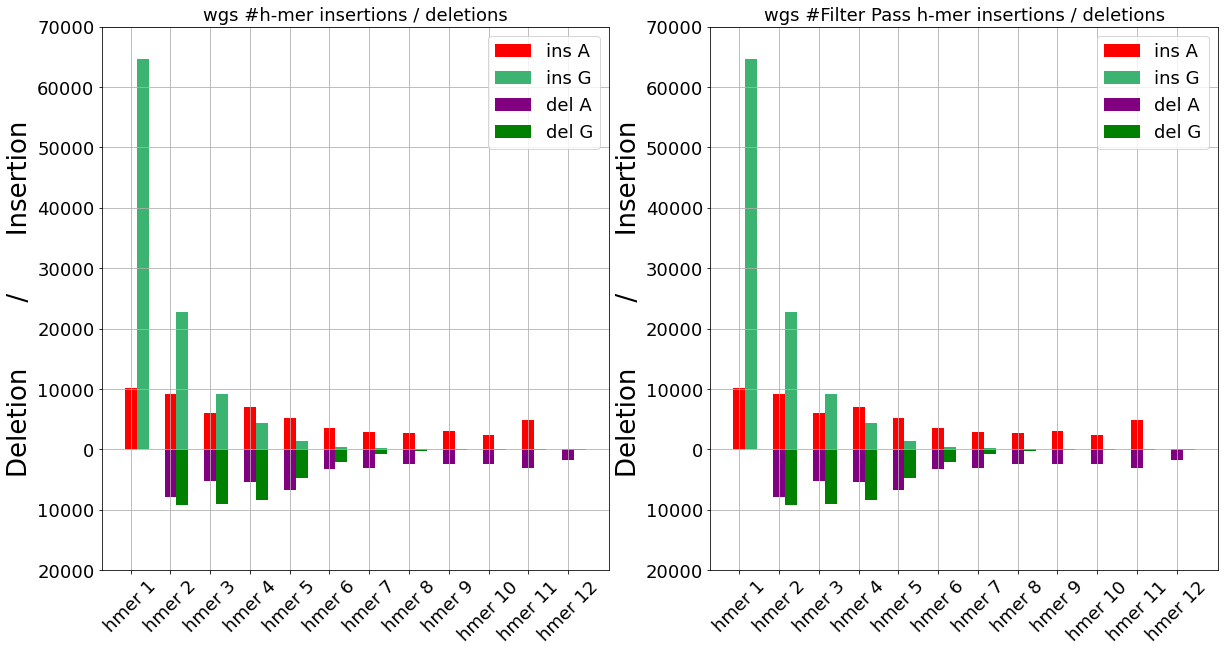

In [41]:
annotation_name = 'wgs'    
ins_del_hete = pd.read_hdf(no_gt_statistics_unfiltered_wgs,'ins_del_hete')
ins_del_hete.columns = pd.Series(ins_del_hete.columns).apply(lambda x: f"h-mer {x}")
filtered_ins_del_hete = pd.read_hdf(no_gt_statistics_filtered_wgs,'ins_del_hete')
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

ins_del_hete_graph(ins_del_hete, axes[0], f'{annotation_name} #h-mer insertions / deletions')
ins_del_hete_graph(filtered_ins_del_hete, axes[1], f'{annotation_name} #Filter Pass h-mer insertions / deletions')

In [42]:
if not is_somatic:
    display(Markdown("""## Homozygous
    """))

In [43]:
if not is_somatic:
    ins_del_homo = pd.read_hdf(no_gt_statistics_unfiltered_wgs,'ins_del_homo')
    ins_del_homo.columns = pd.Series(ins_del_homo.columns).apply(lambda x: f"h-mer {x}")
    filtered_ins_del_homo = pd.read_hdf(no_gt_statistics_filtered_wgs,'ins_del_homo')
    fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(20, 10))

    ins_del_hete_graph(ins_del_homo, axes[0], f'wgs # insertions / deletions')
    ins_del_hete_graph(filtered_ins_del_homo, axes[1], f'wgs #Filter Pass insertions / deletions')